In [ ]:
file_path = "/content/Cit-HepTh.txt"

with open(file_path, "r") as file:
    for _ in range(10):
        print(file.readline().strip())


# Directed graph (each unordered pair of nodes is saved once): Cit-HepTh.txt
# Paper citation network of Arxiv High Energy Physics Theory category
# Nodes: 27770 Edges: 352807
# FromNodeId	ToNodeId
1001	9304045
1001	9308122
1001	9309097
1001	9311042
1001	9401139
1001	9404151


In [ ]:
import tarfile

with tarfile.open("/content/cit-HepTh-abstracts.tar.gz", "r:gz") as tar:
    tar.extractall(path="/content/cit-HepTh-abstracts")

print(" Abstracts extracted.")




 Abstracts extracted.


In [ ]:
import re
from pathlib import Path
import pandas as pd


base_path = Path("/content/cit-HepTh-abstracts")
metadata_records = []

# mapping function for field classification
def map_to_field(raw_text):
    raw_text = raw_text.lower()
    if "phenomenology" in raw_text:
        return "hep-ph"
    elif "experiment" in raw_text:
        return "hep-ex"
    elif "lattice" in raw_text:
        return "hep-lat"
    elif "quantum algebra" in raw_text or "mathematical physics" in raw_text:
        return "hep-th"
    elif any(term in raw_text for term in ["chaotic dynamics", "superconductivity", "quantum hall", "mesoscopic", "statistical mechanics"]):
        return "cond-mat"
    elif any(term in raw_text for term in ["algebraic geometry", "differential geometry", "symplectic", "functional analysis"]):
        return "math-ph"
    elif "theory" in raw_text:
        return "hep-th"
    else:
        return "other"

# Iterate through all files
for year_folder in base_path.iterdir():
    if year_folder.is_dir():
        for file in year_folder.glob("*.abs"):
            try:
                with open(file, "r", encoding="utf-8", errors="ignore") as f:
                    lines = f.readlines()
                paper_id = int(file.stem)
                field_line = next((line for line in lines if "Subj-class:" in line), None)
                if field_line:
                    raw_subject = field_line.replace("Subj-class:", "").strip()
                    field = map_to_field(raw_subject)
                    metadata_records.append({"paper_id": paper_id, "field": field})
            except Exception as e:
                print(f"Error reading {file.name}: {e}")


metadata_df = pd.DataFrame(metadata_records)
metadata_df.to_csv("/content/metadata.csv", index=False)
metadata_df['field'].value_counts(), metadata_df.head()


(field
 hep-th      1900
 math-ph      439
 cond-mat     204
 Name: count, dtype: int64,
    paper_id   field
 0   9305036  hep-th
 1   9307008  hep-th
 2   9310022  hep-th
 3   9304138  hep-th
 4   9301011  hep-th)

In [ ]:
# Clean up
metadata_df["field"] = metadata_df["field"].str.strip().str.replace(r"[^\w\-]+", "", regex=True)


metadata_df.to_csv("/content/metadata.csv", index=False)

metadata_df['field'].value_counts()


,count
field,
hep-th,1900
math-ph,439
cond-mat,204


In [ ]:
import gzip

#Load the submission dates file
with gzip.open("/content/cit-HepTh-dates.txt.gz", 'rt') as f:
    time_df = pd.read_csv(f, sep='\t', header=None, names=["paper_id", "date"])

# Remove comments and clean paper IDs
time_df = time_df[~time_df['paper_id'].astype(str).str.startswith('#')].copy()
time_df['paper_id'] = time_df['paper_id'].astype(int)
time_df['date'] = pd.to_datetime(time_df['date'])

# Load your metadata (fields per paper)
metadata = pd.read_csv("/content/metadata.csv")  # Update path if needed

# Merge metadata with dates
merged_df = pd.merge(metadata, time_df, on="paper_id", how="inner")

# Add 'year' column
merged_df['year'] = merged_df['date'].dt.year

# save
merged_df.to_csv("/content/metadata_with_dates.csv", index=False)


print(" metadata_with_dates.csv created.")
merged_df.head()


 metadata_with_dates.csv created.


,paper_id,field,date,year
0,9312213,hep-th,1993-12-02,1993
1,9310201,hep-th,1993-10-01,1993
2,9312210,hep-th,1993-12-01,1993
3,9312214,hep-th,1993-12-02,1993
4,9411208,hep-th,1994-11-02,1994


In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

 Number of Papers (Nodes): 27770
 Number of Citations (Edges): 352807

 COIN Matrix (Citation Flow Between Fields):
          cond-mat  hep-th  math-ph
cond-mat       125     122        7
hep-th          93    2862      362
math-ph          0     187      833
 Introspection for cond-mat: 0.4921
 Introspection for hep-th: 0.8628
 Introspection for math-ph: 0.8167
 Export-Import Ratio for cond-mat: 1.3871
 Export-Import Ratio for hep-th: 1.4725
 Export-Import Ratio for math-ph: 0.5068


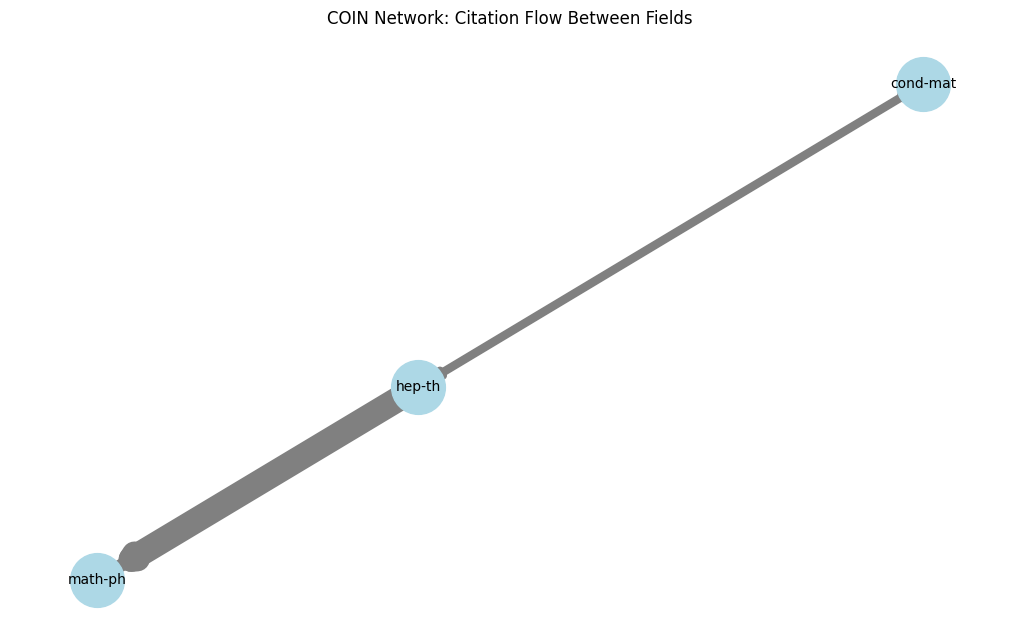

In [ ]:
# load data
file_path = "/content/Cit-HepTh.txt"

edges = []
with open(file_path, "r") as f:
    for line in f:
        if line.startswith("#"):
            continue
        source, target = map(int, line.strip().split())
        edges.append((source, target))

G = nx.DiGraph()
G.add_edges_from(edges)

print(f" Number of Papers (Nodes): {G.number_of_nodes()}")
print(f" Number of Citations (Edges): {G.number_of_edges()}")

# Load Metadata and Assign Fields
metadata = pd.read_csv("metadata.csv")
paper_field_map = dict(zip(metadata["paper_id"], metadata["field"]))
nx.set_node_attributes(G, paper_field_map, "field")

#  COIN Matrix
fields = sorted(metadata["field"].unique())
field_indices = {field: idx for idx, field in enumerate(fields)}
n = len(fields)
coin_matrix = np.zeros((n, n), dtype=int)

for u, v in G.edges():
    field_u = G.nodes[u].get("field")
    field_v = G.nodes[v].get("field")
    if field_u and field_v:
        i, j = field_indices[field_u], field_indices[field_v]
        coin_matrix[i, j] += 1

coin_df = pd.DataFrame(coin_matrix, index=fields, columns=fields)
print("\n COIN Matrix (Citation Flow Between Fields):")
print(coin_df)

# Computing Self-Citation Ratio (Introspection) per Field
introspection_scores = {}
for field in fields:
    i = field_indices[field]
    self_cites = coin_matrix[i, i]
    total_cites = np.sum(coin_matrix[i, :])
    ratio = self_cites / total_cites if total_cites > 0 else 0
    print(f" Introspection for {field}: {ratio:.4f}")

# Export-Import Ratio per Field
export_import_scores = {}
for field in fields:
    i = field_indices[field]
    exports = np.sum(coin_matrix[i, :]) - coin_matrix[i, i]
    imports = np.sum(coin_matrix[:, i]) - coin_matrix[i, i]
    ratio = exports / imports if imports > 0 else float('inf')
    print(f" Export-Import Ratio for {field}: {ratio:.4f}")

# Visualize the COIN Network
H = nx.DiGraph()
for i, f_from in enumerate(fields):
    for j, f_to in enumerate(fields):
        if coin_matrix[i, j] > 0 and f_from != f_to:
            H.add_edge(f_from, f_to, weight=coin_matrix[i, j])

pos = nx.spring_layout(H, seed=42)
plt.figure(figsize=(10, 6))
edges, weights = zip(*nx.get_edge_attributes(H, 'weight').items())
nx.draw(H, pos, with_labels=True, node_size=1500, node_color="lightblue", font_size=10, arrows=True)
nx.draw_networkx_edges(H, pos, edge_color='gray', width=[w/20 for w in weights])
plt.title("COIN Network: Citation Flow Between Fields")
plt.show()


Starting time-sliced analysis...
Loading and preparing data
Building citation graph...
Analyzing window: 1993-1994...
Analyzing window: 1995-1996...
Analyzing window: 1997-1998...
Analyzing window: 1999-2000...
Analyzing window: 2001-2002...
Generating visualizations...


<ipython-input-10-5eb7aceb107e>:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(time_labels, rotation=45)
<ipython-input-10-5eb7aceb107e>:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(time_labels, rotation=45)
<ipython-input-10-5eb7aceb107e>:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(time_labels, rotation=45)
<ipython-input-10-5eb7aceb107e>:204: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(time_labels, rotation=45)



Field Trajectory Analysis Results:
cond-mat: Emerging
hep-th: Emerging
math-ph: Emerging

Analysis complete! Visualizations saved to: /content/time_analysis_results


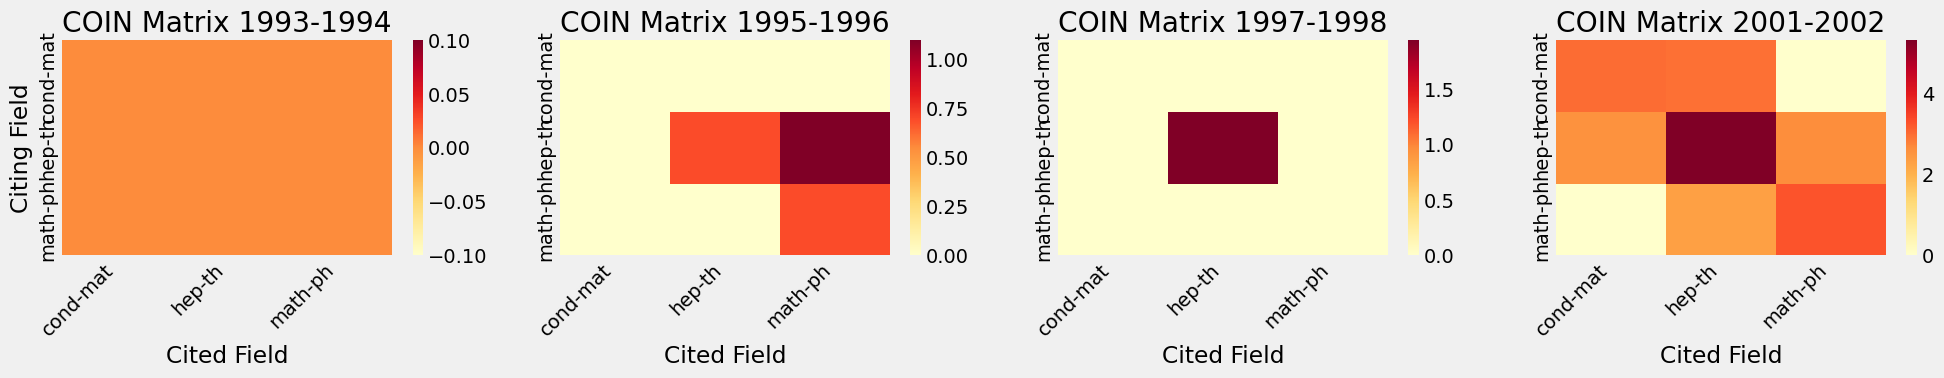

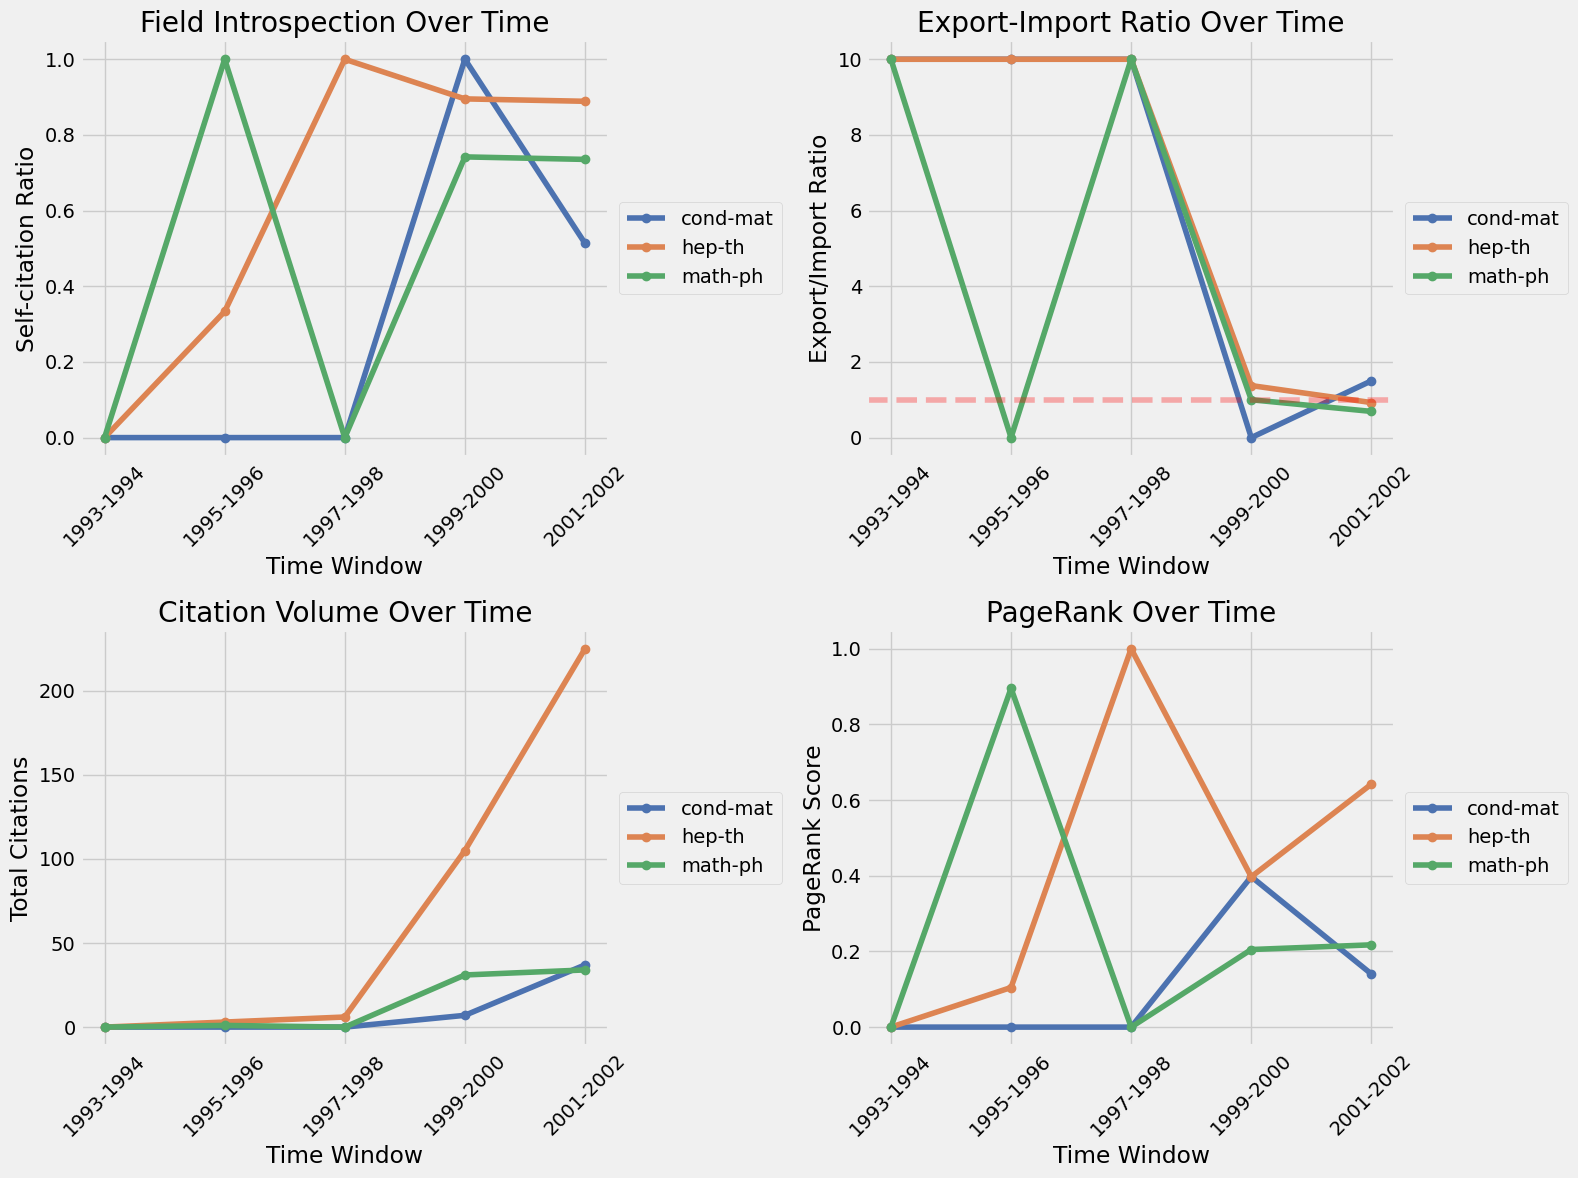

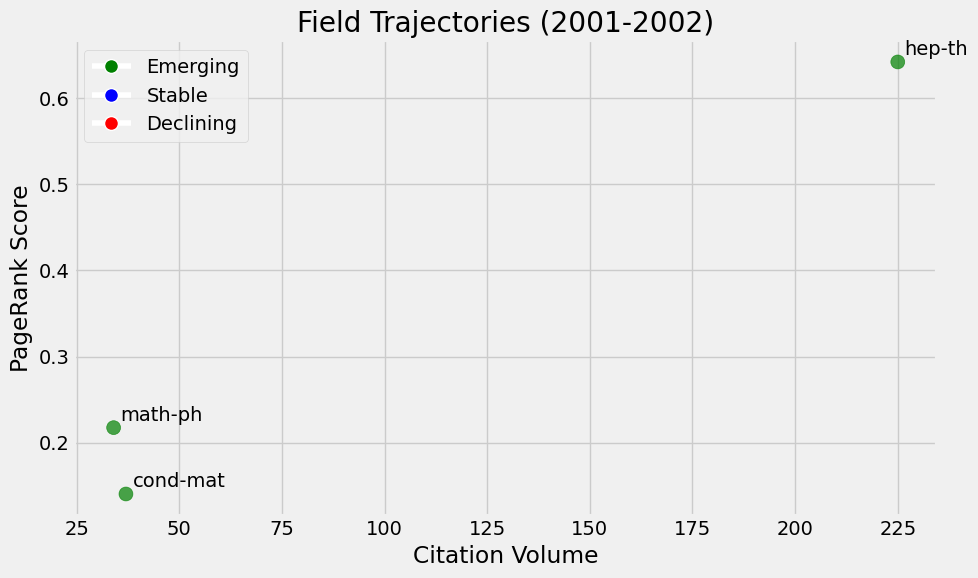

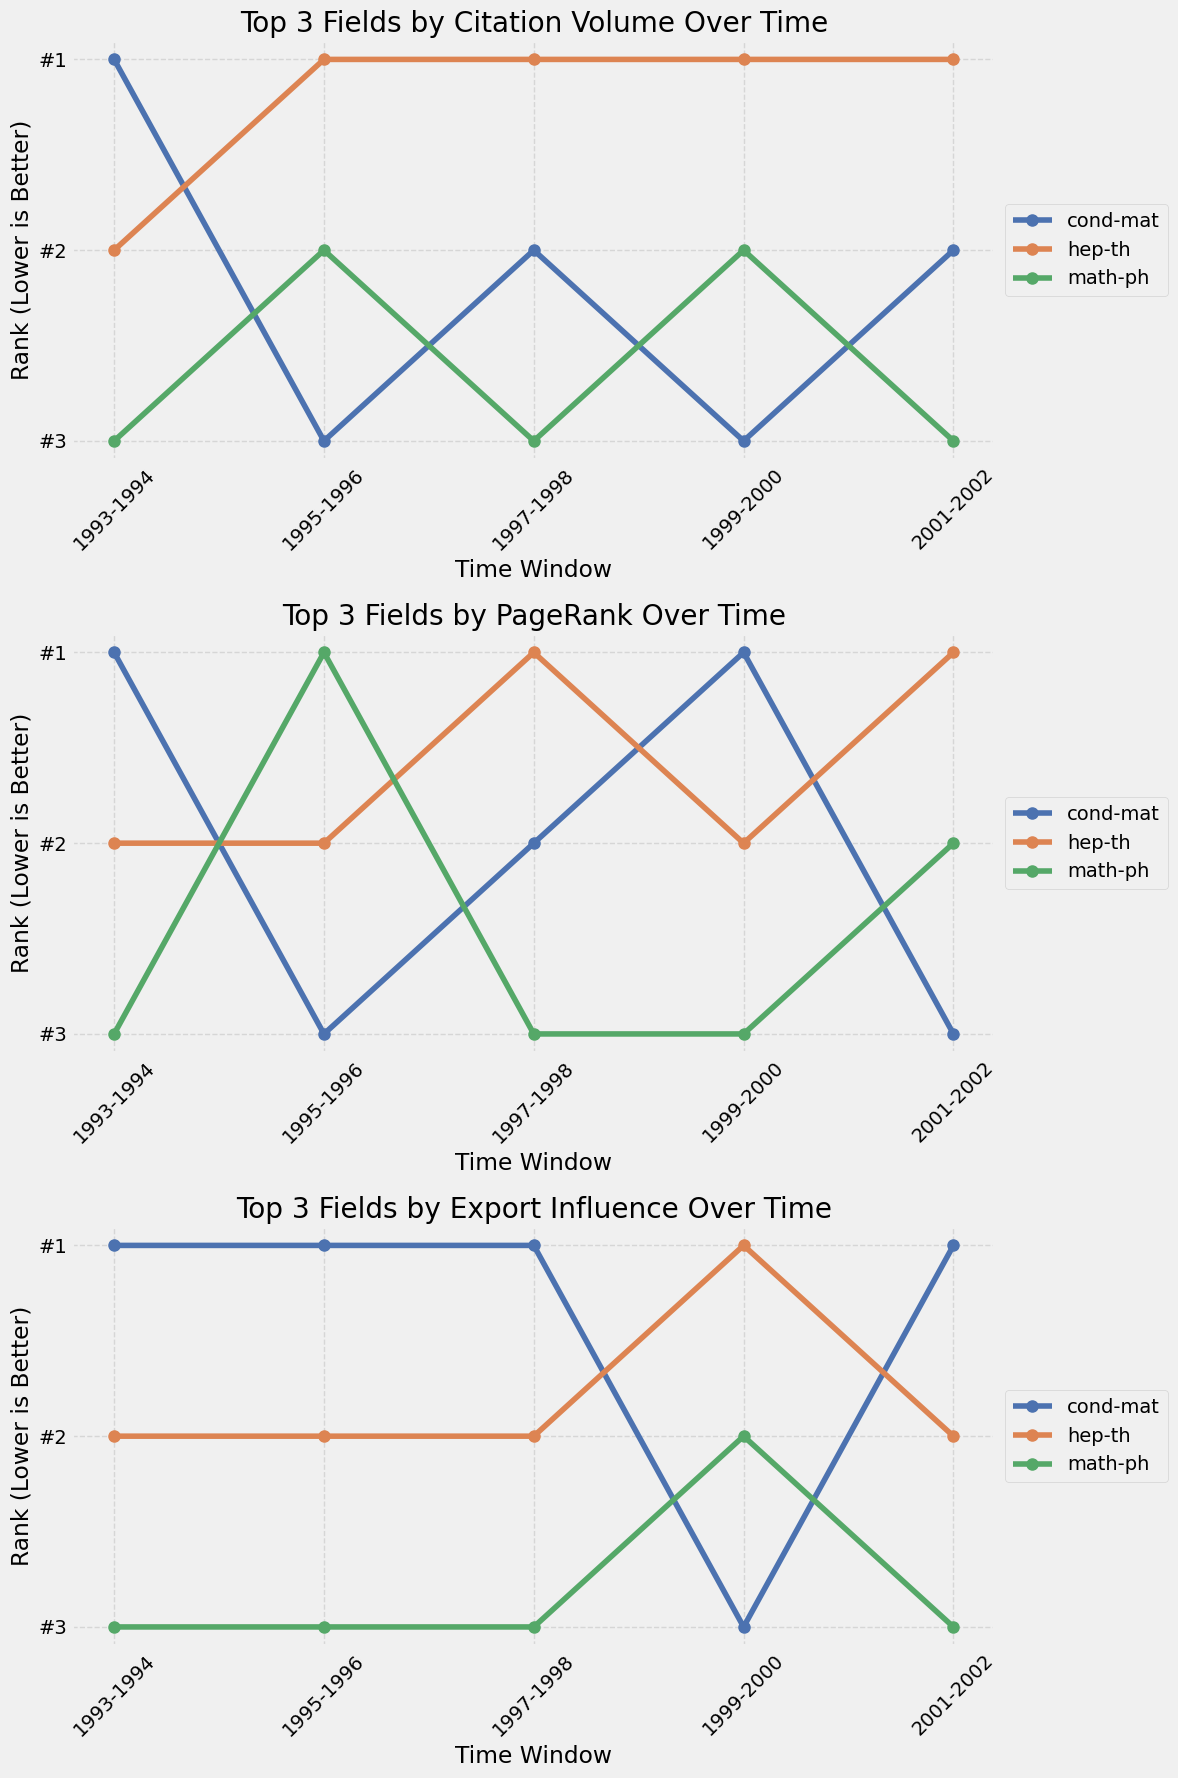

In [ ]:
#Library Imports
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
from pathlib import Path
from matplotlib.lines import Line2D
plt.style.use('fivethirtyeight')
sns.set_palette("deep")


def time_sliced_analysis(citation_path, metadata_path, window_size=2):

    print("Loading and preparing data")

    # Loading metadata and convert date info
    metadata = pd.read_csv(metadata_path)
    metadata['date'] = pd.to_datetime(metadata['date'])
    metadata['year'] = metadata['date'].dt.year

    # Mapping each paper to its field
    paper_to_field = dict(zip(metadata["paper_id"], metadata["field"]))

    # Reading citation edges
    print("Building citation graph...")
    citations = []
    with open(citation_path, "r") as f:
        for line in f:
            if line.startswith("#"): continue
            source, target = map(int, line.strip().split())
            citations.append((source, target))

    # Create directed graph from citations
    G = nx.DiGraph()
    G.add_edges_from(citations)

    # Field metadata to graph nodes
    nx.set_node_attributes(G, paper_to_field, "field")

    # Time window
    min_year, max_year = metadata['year'].min(), metadata['year'].max()
    time_windows = [(year, year + window_size - 1) for year in range(min_year, max_year + 1, window_size)]

    fields = sorted(metadata['field'].unique())
    field_index = {field: i for i, field in enumerate(fields)}
    num_fields = len(fields)

    # Storage for metrics over time
    time_series = {
        'introspection': {f: [] for f in fields},
        'export_import': {f: [] for f in fields},
        'pagerank': {f: [] for f in fields},
        'citation_volume': {f: [] for f in fields},
        'coin_matrices': [],
        'time_labels': []
    }

    # Analyze each time slice
    for start_year, end_year in time_windows:
        print(f"Analyzing window: {start_year}-{end_year}...")

        # Get papers published in this time window
        papers_in_window = metadata[
            (metadata['year'] >= start_year) & (metadata['year'] <= end_year)
        ]['paper_id'].tolist()

        # Build subgraph for this window
        G_window = G.subgraph(papers_in_window)

        # Create COIN matrix rows = citing field, cols = cited field
        coin_matrix = np.zeros((num_fields, num_fields), dtype=int)

        for citing, cited in G_window.edges():
            field_from = G_window.nodes[citing].get("field")
            field_to = G_window.nodes[cited].get("field")

            if field_from in field_index and field_to in field_index:
                i, j = field_index[field_from], field_index[field_to]
                coin_matrix[i, j] += 1

        # Store COIN matrix and label
        time_series['coin_matrices'].append(coin_matrix)
        time_series['time_labels'].append(f"{start_year}-{end_year}")


        for field in fields:
            i = field_index[field]

            total_outgoing = np.sum(coin_matrix[i, :])
            total_incoming = np.sum(coin_matrix[:, i])

            #  Introspection (Self-citation ratio)
            self_citations = coin_matrix[i, i]
            introspection_ratio = self_citations / total_outgoing if total_outgoing > 0 else 0
            time_series['introspection'][field].append(introspection_ratio)

            #  Export/Import Ratio
            exports = total_outgoing - self_citations
            imports = total_incoming - self_citations
            ratio = exports / imports if imports > 0 else 10  # Cap infinite values
            time_series['export_import'][field].append(ratio)

            #  Citation Volume
            time_series['citation_volume'][field].append(total_outgoing)

        #  PageRank on field-level network
        field_graph = nx.DiGraph()
        for i, f_from in enumerate(fields):
            for j, f_to in enumerate(fields):
                weight = coin_matrix[i, j]
                if weight > 0:
                    field_graph.add_edge(f_from, f_to, weight=weight)

        try:
            pagerank = nx.pagerank(field_graph, alpha=0.85, weight='weight')
        except:
            pagerank = {f: 0 for f in fields}

        for field in fields:
            time_series['pagerank'][field].append(pagerank.get(field, 0))

    return time_series, fields, time_series['time_labels']

def visualize_coin_evolution(time_series, fields, time_labels, sample_points=4):

    n_windows = len(time_series['coin_matrices'])

    # Pick equally spaced sample points (or use all if fewer)
    indices = (list(range(n_windows)) if n_windows <= sample_points else
               [int(i * (n_windows-1) / (sample_points-1)) for i in range(sample_points)])

    fig, axes = plt.subplots(1, len(indices), figsize=(5*len(indices), 4))
    if len(indices) == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i, idx in enumerate(indices):
        matrix = np.log1p(time_series['coin_matrices'][idx])  # log1p for stability
        label = time_labels[idx]

        sns.heatmap(matrix, ax=axes[i], cmap="YlOrRd",
                    xticklabels=fields, yticklabels=fields, cbar=True)

        axes[i].set_title(f"COIN Matrix {label}")
        axes[i].set_xlabel("Cited Field")
        if i == 0:
            axes[i].set_ylabel("Citing Field")

        # Improve readability
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    return fig

def visualize_field_trends(time_series, fields, time_labels):

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    metric_names = ['introspection', 'export_import', 'citation_volume', 'pagerank']
    y_labels = [
        "Self-citation Ratio",
        "Export/Import Ratio",
        "Total Citations",
        "PageRank Score"
    ]
    titles = [
        "Field Introspection Over Time",
        "Export-Import Ratio Over Time",
        "Citation Volume Over Time",
        "PageRank Over Time"
    ]

    for idx, metric in enumerate(metric_names):
        for field in fields:
            series = time_series[metric][field]
            if len(series) == len(time_labels):
                axes[idx].plot(time_labels, series, marker='o', label=field)

        axes[idx].set_title(titles[idx])
        axes[idx].set_xlabel("Time Window")
        axes[idx].set_ylabel(y_labels[idx])
        axes[idx].set_xticklabels(time_labels, rotation=45)
        axes[idx].legend(loc='center left', bbox_to_anchor=(1, 0.5))

        if metric == "export_import":
            axes[idx].axhline(y=1, color='r', linestyle='--', alpha=0.3)

    plt.tight_layout()
    return fig

def field_trajectory_analysis(time_series, fields, time_labels):

    growth = {'citation_volume': {}, 'pagerank': {}, 'combined_score': {}}

    for field in fields:
        #  Citation volume growth
        v0 = time_series['citation_volume'][field][0]
        v1 = time_series['citation_volume'][field][-1]
        growth['citation_volume'][field] = (v1 - v0) / v0 if v0 else v1

        #  PageRank growth
        p0 = time_series['pagerank'][field][0]
        p1 = time_series['pagerank'][field][-1]
        growth['pagerank'][field] = (p1 - p0) / p0 if p0 else p1

        #  Combined score
        growth['combined_score'][field] = (
            growth['citation_volume'][field] + growth['pagerank'][field]) / 2

    # Classify fields
    trajectories = {}
    for field, score in growth['combined_score'].items():
        if score > 0.5:
            trajectories[field] = "Emerging"
        elif score < -0.3:
            trajectories[field] = "Declining"
        else:
            trajectories[field] = "Stable"

    # Scatterplot
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = {"Emerging": "green", "Stable": "blue", "Declining": "red"}
    x, y, c, labels = [], [], [], []

    for field in fields:
        if field in trajectories:
            x.append(time_series['citation_volume'][field][-1])
            y.append(time_series['pagerank'][field][-1])
            c.append(colors[trajectories[field]])
            labels.append(field)

    scatter = ax.scatter(x, y, c=c, s=100, alpha=0.7)
    for i, label in enumerate(labels):
        ax.annotate(label, (x[i], y[i]), xytext=(5, 5), textcoords='offset points')

    ax.set_title(f"Field Trajectories ({time_labels[-1]})")
    ax.set_xlabel("Citation Volume")
    ax.set_ylabel("PageRank Score")

    legend_elements = [Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color, markersize=10, label=label)
                       for label, color in colors.items()]
    ax.legend(handles=legend_elements)

    plt.tight_layout()
    return trajectories, fig

def dynamic_field_rankings(time_series, fields, time_labels):

    rankings = {'citation_volume': [], 'pagerank': [], 'export_influence': []}

    for t in range(len(time_labels)):
        # Prepare rankings for each metric at time t
        for metric in rankings:
            series = time_series['citation_volume'] if metric == 'citation_volume' else \
                     time_series['pagerank'] if metric == 'pagerank' else \
                     time_series['export_import']

            ranked = sorted(
                [(f, series[f][t]) for f in fields if t < len(series[f])],
                key=lambda x: x[1], reverse=True
            )
            rankings[metric].append(ranked)

    # Plot rankings
    top_n = min(5, len(fields))
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))
    metrics = ['Citation Volume', 'PageRank', 'Export Influence']

    for i, (metric, label) in enumerate(zip(rankings, metrics)):
        plot_ranking_evolution(rankings[metric], time_labels, label, axes[i], top_n)

    plt.tight_layout()
    return rankings, fig

def plot_ranking_evolution(rankings, time_labels, metric_name, ax, top_n):

    field_ranks = defaultdict(list)

    for t, ranking in enumerate(rankings):
        for rank, (field, _) in enumerate(ranking[:top_n]):
            field_ranks[field].append((t, rank))

    for field, points in field_ranks.items():
        times, ranks = zip(*points)
        ax.plot(times, ranks, 'o-', label=field, markersize=8)

    ax.set_title(f"Top {top_n} Fields by {metric_name} Over Time")
    ax.set_xlabel("Time Window")
    ax.set_ylabel("Rank (Lower is Better)")
    ax.set_yticks(range(top_n))
    ax.set_yticklabels([f"#{i+1}" for i in range(top_n)])
    ax.set_xticks(range(len(time_labels)))
    ax.set_xticklabels(time_labels, rotation=45)
    ax.invert_yaxis()
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

citation_path = "/content/Cit-HepTh.txt"
metadata_path = "/content/metadata_with_dates.csv"
output_dir = "/content/time_analysis_results"


time_series, field_trajectories, rankings = run_time_sliced_analysis(
    citation_path,
    metadata_path,
    output_dir,
    window_size=2
)
